In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

import plotly.graph_objects as go
import plotly.express as px
import plotly.colors

import numpy as np
import pandas as pd
import tqdm

from mvf_bto.data_loading import load_data

## Loading Data

In [4]:
# data_path = "/Users/anoushkabhutani/PycharmProjects/10701-mvf-bto/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
# data_path = "/home/amalss/Documents/CMU/Courses/10701/project/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
data_path = "/Users/mac/Desktop/CMU/10701MachineLearning/project/10701-mvf-bto-backup/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"

In [5]:
data = load_data(file_path= data_path, num_cells= 3)

100%|██████████| 3/3 [00:26<00:00,  8.85s/it]


In [6]:
single_cell_data = data['b1c2']['cycles']

## Preprocessing Data

In [33]:
df_list = []
max_cycle = 1175
for cycle_key, time_series in tqdm.tqdm(single_cell_data.items()):
    cycle_num = int(cycle_key)
    if cycle_num<1:
        continue
    df = pd.DataFrame({'t': time_series['t'], 
                       'V': time_series['V'],
                       'temp': time_series['T'],
                       'I': time_series['I'],
                       'Qd': time_series['Qd'],
                      }
                       )
    # drop duplicates to be able to interpolate over capacity
    df = df.drop_duplicates(subset='Qd')
    
    
    # get discharge part of curve only (current is negative during discharge)
    df = df[df.I<-3.85]
    
    # normalize voltage and temperature using fixed thershold's to avoid data leakage
    df['V_norm'] = (df.V-1.9)/(3.5-1.9)
    df['T_norm'] = (df.temp-24)/(38-24)
    
    interp_df = pd.DataFrame()
    # use capacity as reference to interpolate over
    Q_eval = [0, 0.0125, 0.025, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.85, 0.9, 0.95, 0.975, 0.98, 0.99, 1.0, 1.005, 1.01, 1.015, 1.02]
    interp_df['Q_eval'] = Q_eval
    fV = interp1d(x=df.Qd, y =df.V_norm, kind='quadratic', fill_value='extrapolate')
    interp_df['V_norm'] = fV(Q_eval)
    ft = interp1d(x=df.Qd, y =df.t, kind='quadratic', fill_value='extrapolate')
    interp_df['t'] = ft(Q_eval)
    fT = interp1d(x=df.Qd, y =df['T_norm'], kind='quadratic', fill_value='extrapolate')
    interp_df['T_norm'] = fT(Q_eval)
    
    interp_df['Cycle'] = [cycle_num/max_cycle for i in range(len(interp_df))]
    
    df_list.append(interp_df)

100%|██████████| 1176/1176 [00:07<00:00, 161.61it/s]


## What does raw versus interpolated data look like?

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df.Qd, y = df.V_norm, showlegend=True, mode="markers", name="Raw"))
fig.add_trace(go.Scatter(x = interp_df.Q_eval, y = interp_df.V_norm, showlegend=True, mode="markers+lines" , name="Interpolated"))

In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df.t, y = df.V_norm, showlegend=True, mode="markers", name="Raw"))
fig.add_trace(go.Scatter(x = interp_df.t, y = interp_df.V_norm, showlegend=True, mode="markers+lines" , name="Interpolated"))

In [24]:
# multivariate data preparation
# TODO: multi output (temperature + voltage) (Hancheng)
# TODO: multiple time steps in the future 
X_list, y_list = [], []

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
            # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix-1, :-2], sequences[end_ix-1, -2:]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

for df in df_list:
    # define input sequence
    in_seq1 = df['T_norm'].values
    in_seq2 = df['Q_eval'].values
    in_seq3 = df['V_norm'].values
    in_seq4 = df['Cycle'].values
    out_seq1 = df['V_norm'].values
    out_seq2 = df['T_norm'].values
    
    # convert to [rows, columns] structure
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
    in_seq4 = in_seq4.reshape((len(in_seq4), 1))#cycle
    out_seq1 = out_seq1.reshape((len(out_seq1), 1))#voltage
    out_seq2 = out_seq2.reshape((len(out_seq2), 1))#temperature
    
    # horizontally stack columns
    dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, out_seq1, out_seq2))
    
    # choose a number of time steps (for input window)
    n_steps = 4
    
    # convert into input/output
    X_cycle, y_cycle = split_sequences(dataset, n_steps)
    X_list.append(X_cycle)
    y_list.append(y_cycle)

In [25]:
batch_size = X_cycle.shape[0] 
# batch_size must be equal to the length of 1 input curve
# since for a stateful LSTM the cell state is cleared after a batch
# (look at the keras docs)
# we could write over own custom callback if we need batch_size != sequence_length
# (for the use t prediction as t+1 input case)
# but I'm not sure if that's acceptable practice

window_length = X_cycle.shape[1]
n_features = X_cycle.shape[2]
print(batch_size, window_length, n_features)
print(len(X_list),len(y_list))

19 3 4
1175 1175


In [26]:
X_train = np.array([item for index, item in enumerate(X_list) if index % 100 != 0])
X_test = np.array([item for index, item in enumerate(X_list) if index % 100 == 0])

y_train = np.array([item for index, item in enumerate(y_list) if index % 100 != 0])
y_test = np.array([item for index, item in enumerate(y_list) if index % 100 == 0])

# y_test = y_test.flatten()
# y_train = y_train.flatten()

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

X_train = X_train.reshape(X_train.shape[0]*batch_size, X_train[0].shape[1] , X_train.shape[-1])
X_test = X_test.reshape(X_test.shape[0]*batch_size,X_test[0].shape[1], X_test.shape[-1])
print(X_train.shape,X_test.shape)

y_train = y_train.reshape(y_train.shape[0]*batch_size, y_train[0].shape[-1])
y_test = y_test.reshape(y_test.shape[0]*batch_size, y_test[0].shape[-1])
print(y_train.shape,y_test.shape)

(1163, 19, 3, 4) (12, 19, 3, 4)
(1163, 19, 2) (12, 19, 2)
(22097, 3, 4) (228, 3, 4)
(22097, 2) (228, 2)


In [27]:
# sample_weight = np.ones(y_train.shape)

# # TODO: experiment with different sample weights and thersholds
# # (this is a arbitary guess)
# sample_weight[y_train<0.6]=2
# sample_weight[y_train<0.5]=3

In [41]:
# define model
# TODO: hyperparameter tuning (Anoushka)
model = Sequential()
model.add(LSTM(32, return_sequences=True, stateful=True, batch_input_shape=(batch_size, window_length, n_features)))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation="sigmoid"))
model.add(Dense(8))
# need to change here (maybe) if n steps into the future
model.add(Dense(2))

model.compile(optimizer='adam', loss='mse')

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (19, 3, 32)               4736      
                                                                 
 lstm_5 (LSTM)               (19, 16)                  3136      
                                                                 
 dense_6 (Dense)             (19, 32)                  544       
                                                                 
 dense_7 (Dense)             (19, 8)                   264       
                                                                 
 dense_8 (Dense)             (19, 2)                   18        
                                                                 
Total params: 8,698
Trainable params: 8,698
Non-trainable params: 0
_________________________________________________________________


In [43]:
# TODO: add validation set or validation split + early stopping
n_epochs = 150

history = model.fit(X_train, y_train, 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    shuffle=False, 
                    verbose=1, 
                    sample_weight=sample_weight)

Epoch 1/150
1163/1163 [==============================] - 9s 4ms/step - loss: 0.0642
Epoch 2/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0053
Epoch 3/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0049
Epoch 4/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0043
Epoch 5/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0035
Epoch 6/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0035
Epoch 7/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0035
Epoch 8/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0037
Epoch 9/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0036
Epoch 10/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0031
Epoch 11/150
1163/1163 [==============================] - 5s 4ms/step - loss: 0.0031
Epoch 12/150
1163/1163 [==============================] - 5s 4ms/step - lo

Text(0, 0.5, 'Loss (MSE)')

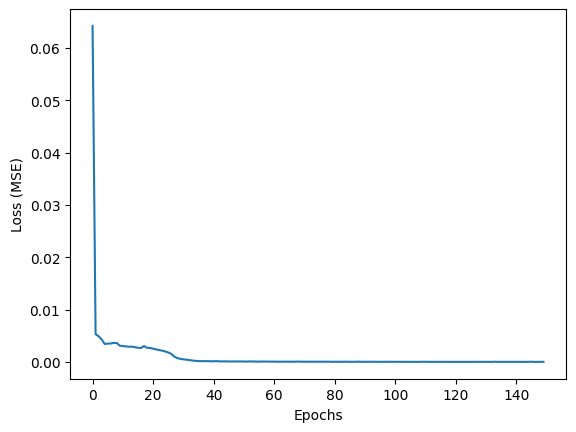

In [44]:
#Matplotlib code
import matplotlib.pyplot as plt 
plt.plot(np.arange(n_epochs), history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = np.linspace(1,150), y = history.history['loss'],
                         showlegend=False, mode="markers+lines"))
fig.update_xaxes(title='Epochs')
fig.update_yaxes(title='Loss (MSE)')

## Parity Plot of Training Error

In [47]:
# random plotting traing error at some interval = skip to not make the plot rendering too slow
skip = 20



# #Matplotlib code
# plt.plot([0, 1], [0, 1], color='black')
# for i in range(0, len(X_train), batch_size*skip):
#     plt.plot(model.predict(X_train[i:i+batch_size], verbose=0).flatten(),
#              y_train[i:i+batch_size], label=f"{i}")

# plt.xlabel("Normalized target")
# plt.ylabel("Normalized prediction")
# # plt.legend()

## Parity Plot of Test Error

In [48]:
# #Matplotlib code
# plt.plot([0, 1], [0, 1], color='black')
# for i in range(0, len(X_test), batch_size):
#     plt.plot(model.predict(X_test[i:i+batch_size], verbose=0).flatten(),
#              y_test[i:i+batch_size], label=f"{i}")
# # 
# plt.xlabel("Normalized target")
# plt.ylabel("Normalized prediction")


In [49]:
# # Matplotlib code
# for i in range(0, len(X_test), batch_size):
#     V_actual = y_test[i:i+batch_size]
#     V_pred = model.predict(X_test[i:i+batch_size],verbose=0).flatten()
#     plt.scatter(Q_eval[3:], V_actual*(3.5-1.9)+1.9, label=f"data-{i}")
#     plt.plot(Q_eval[3:], V_pred*(3.5-1.9)+1.9, label=f"pred-{i}")
#     break
# plt.ylabel("Voltage [V]")
# plt.xlabel("Capacity [Ah]")

In [50]:
# voltage
skip = 20

fig = go.Figure()
fig.add_trace(go.Scatter(x = [0,1], y = [0,1], showlegend=False, mode="markers+lines"))
for i in range(0,len(X_train), batch_size*skip):
    fig.add_trace(go.Scatter(x = model.predict(X_train[i:i+batch_size],verbose=0)[:,0], 
                             y = y_train[i:i+batch_size,0], 
                             showlegend=False, mode="markers+lines"))
fig.update_yaxes(title='Normalized Target')
fig.update_xaxes(title='Normalized Prediction voltage')

In [52]:
# temperature
skip = 20

fig = go.Figure()
fig.add_trace(go.Scatter(x = [0,1], y = [0,1], showlegend=False, mode="markers+lines"))
for i in range(0,len(X_train), batch_size*skip):
    fig.add_trace(go.Scatter(x = model.predict(X_train[i:i+batch_size],verbose=0)[:,1], 
                             y = y_train[i:i+batch_size,1], 
                             showlegend=False, mode="markers+lines"))
fig.update_yaxes(title='Normalized Target')
fig.update_xaxes(title='Normalized Prediction temperature')

In [53]:
pallete = plotly.colors.qualitative.Dark24*10

fig = go.Figure()
fig.add_trace(go.Scatter(x = [0,1], y = [0,1], showlegend=False, mode="markers+lines"))

for i in range(0, len(X_test), batch_size):
    fig.add_trace(go.Scatter(x = model.predict(X_test[i:i+batch_size],verbose=0)[:,0], 
                             y = y_test[i:i+batch_size,0], 
                             showlegend=False, mode="markers+lines", name='batch',
                             line_color = pallete[i]))
fig.update_yaxes(title='Normalized Target')
fig.update_xaxes(title='Normalized Prediction voltage')

In [54]:
pallete = plotly.colors.qualitative.Dark24*10

fig = go.Figure()
fig.add_trace(go.Scatter(x = [0,1], y = [0,1], showlegend=False, mode="markers+lines"))

for i in range(0, len(X_test), batch_size):
    fig.add_trace(go.Scatter(x = model.predict(X_test[i:i+batch_size],verbose=0)[:,1], 
                             y = y_test[i:i+batch_size,1], 
                             showlegend=False, mode="markers+lines", name='batch',
                             line_color = pallete[i]))
fig.update_yaxes(title='Normalized Target')
fig.update_xaxes(title='Normalized Prediction temperature')

In [55]:
fig = go.Figure()
for i in range(0, len(X_test), batch_size):
    V_actual = y_test[i:i+batch_size,0]
    V_pred = model.predict(X_test[i:i+batch_size],verbose=0)[:,0]
    fig.add_trace(go.Scatter(x = Q_eval, y = V_actual*(3.5-1.9)+1.9, 
                             mode='lines', name = 'data', 
                             line_color = pallete[i]))
    fig.add_trace(go.Scatter(x = Q_eval, y = V_pred*(3.5-1.9)+1.9,
                             mode='markers', name = 'prediction', 
                             line_color = pallete[i]))
fig.update_yaxes(title="Voltage [V]")
fig.update_xaxes(title="Capacity [Ah]")

In [56]:
fig = go.Figure()
for i in range(0, len(X_test), batch_size):
    T_actual = y_test[i:i+batch_size,1]
    T_pred = model.predict(X_test[i:i+batch_size],verbose=0)[:,1]
    fig.add_trace(go.Scatter(x = Q_eval, y = T_actual*(38-24)+24,
                             mode='lines', name = 'data', 
                             line_color = pallete[i]))
    fig.add_trace(go.Scatter(x = Q_eval, y = T_pred*(38-24)+24,
                             mode='markers', name = 'prediction', 
                             line_color = pallete[i]))
fig.update_yaxes(title="Temperature [C]")
fig.update_xaxes(title="Capacity [Ah]")

In [59]:
fig = go.Figure()
t=ft(Q_eval)
for i in range(0, len(X_test), batch_size):
    T_actual = y_test[i:i+batch_size,1]
    T_pred = model.predict(X_test[i:i+batch_size],verbose=0)[:,1]
    fig.add_trace(go.Scatter(x = t, y = T_actual*(38-24)+24,
                             mode='lines', name = 'data', 
                             line_color = pallete[i]))
    fig.add_trace(go.Scatter(x = t, y = T_pred*(38-24)+24,
                             mode='markers', name = 'prediction', 
                             line_color = pallete[i]))
fig.update_yaxes(title="Temperature [C]")
fig.update_xaxes(title="time ")